### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [2]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [3]:
##sheet = client.open('Learning Log').sheet1
raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table], sort=True)

raw_df.tail()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
250,0.0,Australia,0.0,2020-03-06T04:33:03,-12.4634,130.8456,Northern Territory,0.0,03-08-2020
251,0.0,US,0.0,2020-02-24T23:33:02,29.3829,-98.6134,"Lackland, TX (From Diamond Princess)",0.0,03-08-2020
252,0.0,US,0.0,2020-03-07T19:53:02,30.3213,-95.4778,"Montgomery County, TX",0.0,03-08-2020
253,0.0,US,0.0,2020-02-24T23:33:02,41.2545,-95.9758,"Omaha, NE (From Diamond Princess)",0.0,03-08-2020
254,0.0,US,0.0,2020-02-24T23:33:02,38.2721,-121.9399,"Travis, CA (From Diamond Princess)",0.0,03-08-2020


In [4]:
raw_df['Last Update'].max()

'2020-03-22T23:43:03'

In [5]:
# Merge duplicate columns with different names
main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']
main_df.loc[main_df['Province/State']=='None', 'Province/State'] = main_df.loc[main_df['Province/State']=='None', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
6,80.0,Mainland China,1.0,1/27/20 23:59,NaN,NaN,Beijing,2.0,01-27-2020
5,1016.0,Mainland China,4.0,2020-02-26T10:13:11,NaN,NaN,Hunan,783.0,02-26-2020
59,10.0,Macau,0.0,2020-02-27T12:43:02,22.1667,113.5500,Macau,8.0,03-02-2020
159,40.0,Georgia,0.0,2020-03-19T10:53:03,42.3154,43.3569,Georgia,1.0,03-19-2020
83,6.0,Belarus,0.0,2020-03-04T12:43:03,53.7098,27.9534,Belarus,0.0,03-05-2020


In [6]:
main_df.sheet_name.str.split('-')

0      [02, 26, 2020]
1      [02, 26, 2020]
2      [02, 26, 2020]
3      [02, 26, 2020]
4      [02, 26, 2020]
            ...      
250    [03, 08, 2020]
251    [03, 08, 2020]
252    [03, 08, 2020]
253    [03, 08, 2020]
254    [03, 08, 2020]
Name: sheet_name, Length: 7926, dtype: object

In [7]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taipei and environs','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taiwan\*','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United Kingdom','UK')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Viet Nam','Vietnam')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau', 'Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [8]:
main_df.describe(include=np.object)

,Country/Region,Province/State,sheet_name,month,day
count,7926,7926,7926,7926,7926
unique,208,465,61,3,31
top,Mainland China,Gansu,03-22-2020,03,22
freq,1889,63,309,5108,431


In [9]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28
1,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24
2,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25
3,Afghanistan,Afghanistan,02,26,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-26
4,Afghanistan,Afghanistan,02,27,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-27
...,...,...,...,...,...,...,...,...,...
7917,occupied Palestinian territory,occupied Palestinian territory,03,12,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-12
7918,occupied Palestinian territory,occupied Palestinian territory,03,14,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-14
7919,occupied Palestinian territory,occupied Palestinian territory,03,15,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-15
7920,occupied Palestinian territory,occupied Palestinian territory,03,16,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-16


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-03-22 21:13:20     5
2020-03-22 21:13:21     1
2020-03-22 21:13:22     1
2020-03-22 21:43:02     5
2020-03-22 21:43:03    18
Name: Last Update, Length: 1860, dtype: int64

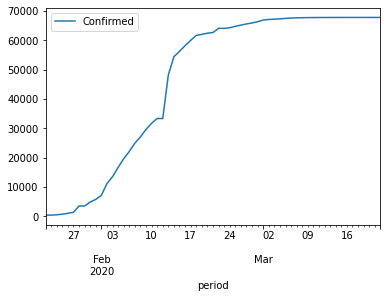

In [10]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [11]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Collin County, TX       1
Johnson County, IA      1
Jefferson County, KY    1
Republic of Moldova     1
Dominica                1
Viet Nam                1
North Ireland           1
Cherokee County, GA     1
Grenada                 1
Harrison County, KY     1
Carver County, MN       1
Ivory Coast             1
St. Martin              1
Ashland, NE             1
Charlotte County, FL    1
Chicago                 1
Fench Guiana            1
Shasta County, CA       1
Queens County, NY       1
Saint Martin            1
Name: Province/State, dtype: int64

In [12]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Collin County, TX', 'Johnson County, IA', 'Jefferson County, KY',
       'Republic of Moldova', 'Dominica', 'Viet Nam', 'North Ireland',
       'Cherokee County, GA', 'Grenada', 'Harrison County, KY'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

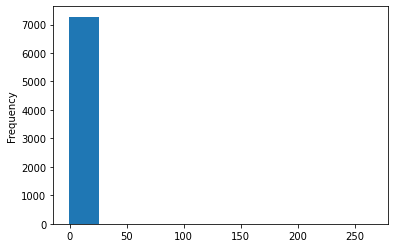

In [13]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

#### Drop province/state with multiple regions

In [14]:
state_count = clean_df.groupby('Province/State')['Country/Region'].nunique().sort_values(ascending=False).reset_index()
state_count
clean_state = state_count.loc[state_count['Country/Region']==1,'Province/State'].to_list()
clean_df = clean_df[clean_df['Province/State'].isin(clean_state)]

In [15]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
255,Australia,Northern Territory,03,06,2020-03-06 02:33:03,0.0,0.0,0.0,2020-03-06,1.0,-1.0,-1.000000
273,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
275,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
518,Azerbaijan,Azerbaijan,03,16,2020-03-16 12:38:45,15.0,6.0,1.0,2020-03-16,23.0,-8.0,-0.347826
547,Bahrain,Bahrain,03,13,2020-03-11 18:00:00,189.0,44.0,0.0,2020-03-13,195.0,-6.0,-0.030769
1104,Cape Verde,Cape Verde,03,22,2020-03-22 09:43:03,0.0,0.0,0.0,2020-03-22,1.0,-1.0,-1.000000
1366,East Timor,East Timor,03,22,2020-03-22 09:13:23,0.0,0.0,0.0,2020-03-22,1.0,-1.0,-1.000000
1866,Guernsey,Guernsey,03,17,2020-03-17 16:33:03,0.0,0.0,0.0,2020-03-17,1.0,-1.0,-1.000000
2281,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
2296,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444


In [16]:
# focus on cases where base is above 20
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 30]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000
mean,1638.438759,598.504317,57.964503,1534.363287,104.075472,0.145310,18.240806
std,7821.057180,4280.268794,362.504001,7619.246150,516.971047,0.222689,15.812579
min,25.000000,0.000000,0.000000,30.000000,-62.000000,-0.444444,1.000000
25%,88.000000,2.000000,0.000000,76.000000,0.000000,0.000000,5.000000
50%,188.000000,23.000000,1.000000,168.000000,8.000000,0.056604,12.000000
75%,544.000000,152.000000,4.000000,520.500000,34.000000,0.219238,30.000000
max,67800.000000,59433.000000,5476.000000,67800.000000,14840.000000,3.024096,60.000000


In [17]:
# growth_df[growth_df.isna().sum(axis=1) <= growth_df.isna().sum(axis=1).shift(-1)]

In [18]:
growth_df = heavy_affect_df.\
    pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').\
    reset_index()

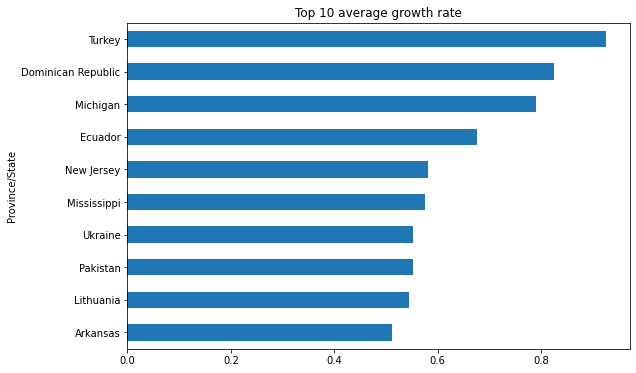

In [19]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().\
    sort_values().iloc[-10:].plot.barh(figsize=(9,6),title='Top 10 average growth rate')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/anaconda3/envs/py37/lib/python

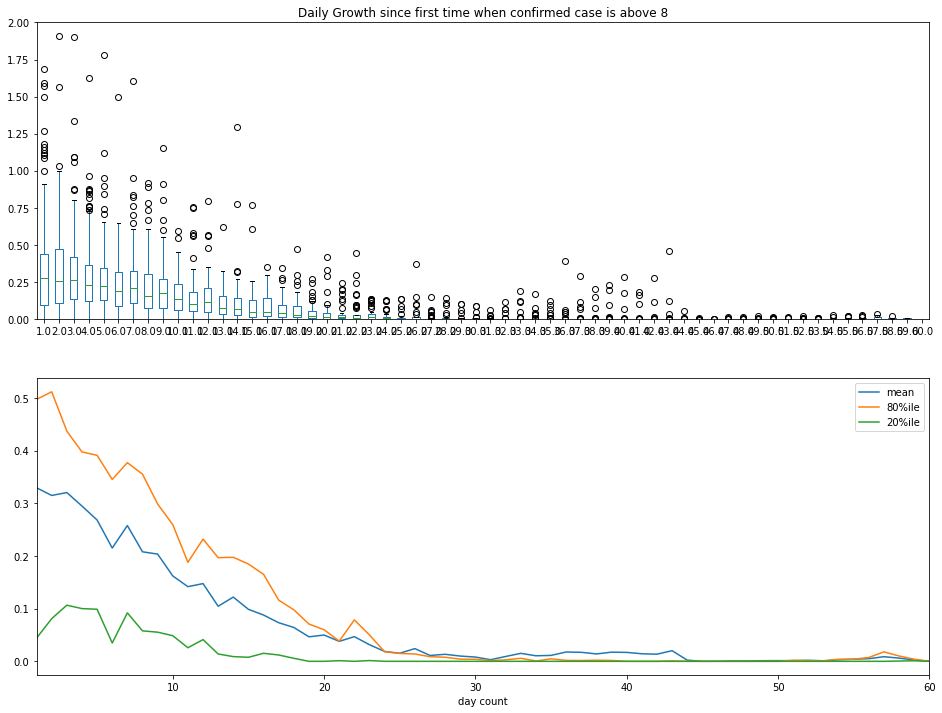

In [20]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize =(16,12))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [21]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
84,"Korea, South",7869.0
172,United Kingdom,1140.0
59,Hubei,444.0
180,Washington,366.0
131,Qatar,262.0


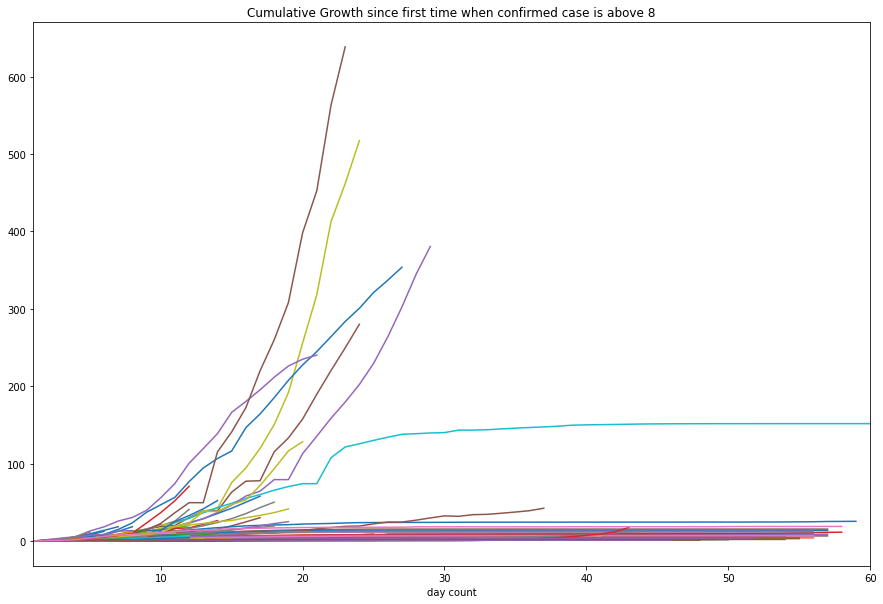

In [22]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(15, 10), 
                         title ='Cumulative Growth since first time when confirmed case is above 8',
                         legend = False)

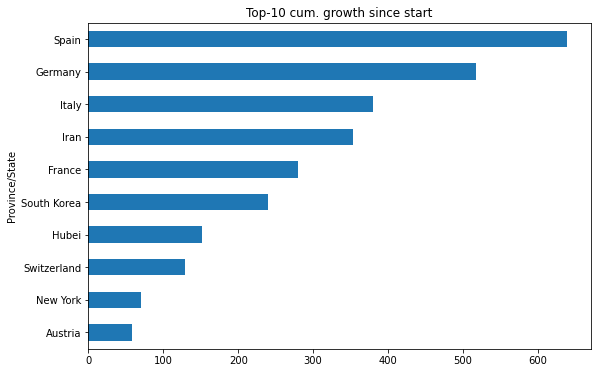

In [23]:
cmlt_growth_df.max().sort_values().iloc[-10:].plot.barh(figsize =(9,6), title='Top-10 cum. growth since start')

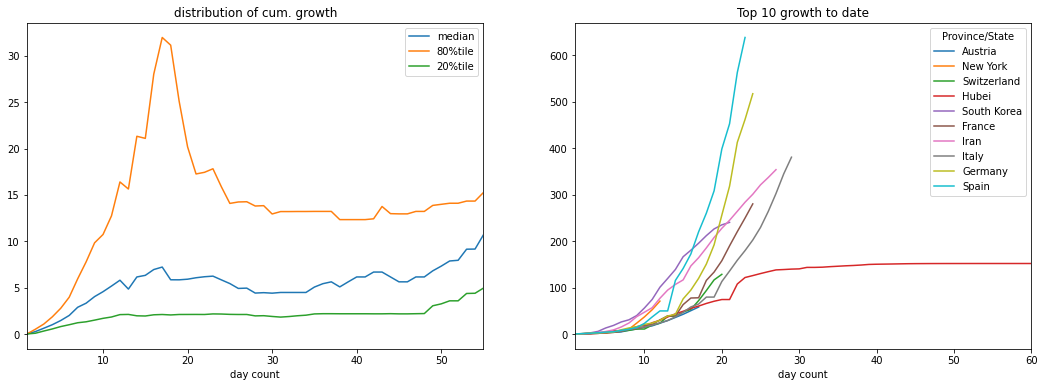

In [24]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.iloc[:-5,:].median(axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['median','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'Top 10 growth to date')

#### Compare China vs. Outside

In [25]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [26]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

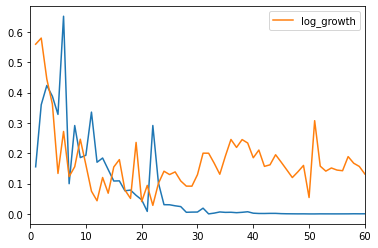

In [27]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

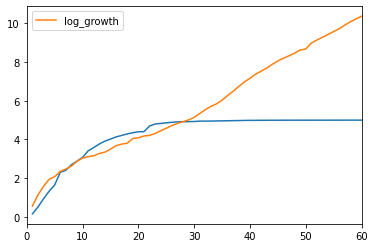

In [28]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [29]:
# The null hypothesis that the two distribution the same is reject by a simple T-test
# Looking closely, the deviation occurs after day 30. This could be due to effectivenss
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-4.014204061598519, pvalue=0.0001051824921040149)

#### Time-series Analysis on Growth Rate

In [30]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.68500784  0.70621277  0.6245197   0.52119182  0.49116785
  0.39718402  0.37835993  0.34903055  0.30601298  0.23823652  0.22237376
  0.16335043  0.11059405  0.10783861  0.02602954  0.12795528  0.06283798
  0.03593769  0.03565368  0.01672388 -0.04502989 -0.09222727 -0.10692598
 -0.12263876 -0.12786944 -0.14490353 -0.15133878 -0.15608826 -0.16516143
 -0.17242766 -0.17888784 -0.18455417 -0.18988907 -0.19667757 -0.20200136
 -0.20685947 -0.21211516 -0.21205637 -0.19747038 -0.20349073]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                  52.756
Method:               Conditional MLE   S.D. of innovations              0.099
Date:                Mon, 23 Mar 2020   AIC                             -4.525
Time:                        08:56:18   BIC                             -4.419
Sample:                             1   HQIC                            -4.483
                                   60                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0237      0.015      1.562      0.118      -0.006       0.053
log_growth.L1     0.6894      0.094      7.301      0.000       0.504       0.875
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4504           +0.0000j            1.4504            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.58602515  0.39909096  0.23051893  0.10426111  0.12608788
  0.09808159  0.09508516  0.00508788 -0.11090282 -0.12437065 -0.16038014
 -0.09578188 -0.06073282 -0.11185115 -0.08607014 -0.1571629  -0.12457418
 -0.14917436 -0.239917   -0.17942205 -0.18169717 -0.10052385 -0.10328295
 -0.13622343 -0.1174184  -0.12960899 -0.10207793 -0.04620865  0.00467925
  0.06053735 -0.00999049  0.06889428  0.05360127  0.10186122  0.16939644
  0.14374723  0.09949222  0.09603645  0.026231    0.01063115]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                  74.760
Method:               Conditional MLE   S.D. of innovations              0.068
Date:                Mon, 23 Mar 2020   AIC                             -5.270
Time:                        08:56:18   BIC                             -5.165
Sample:                             1   HQIC                            -5.229
                                   60                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0642      0.017      3.744      0.000       0.031       0.098
log_growth.L1     0.5880      0.085      6.950      0.000       0.422       0.754
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7007           +0.0000j            1.7007            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore
Note: This model captures "natural" similarities between similar cities, which stopped working after correlations are broken due to different government intervention.

In [32]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Azerbaijan,Azerbaijan,2020-02-28,1.0,0.0,0.0
1,Afghanistan,Afghanistan,2020-02-24,1.0,0.0,0.0
2,Afghanistan,Afghanistan,2020-02-25,1.0,0.0,0.0
3,Afghanistan,Afghanistan,2020-02-26,1.0,0.0,0.0
4,Afghanistan,Afghanistan,2020-02-27,1.0,0.0,0.0
...,...,...,...,...,...,...
5695,occupied Palestinian territory,occupied Palestinian territory,2020-03-12,0.0,0.0,0.0
5696,occupied Palestinian territory,occupied Palestinian territory,2020-03-14,0.0,0.0,0.0
5697,occupied Palestinian territory,occupied Palestinian territory,2020-03-15,0.0,0.0,0.0
5698,occupied Palestinian territory,occupied Palestinian territory,2020-03-16,0.0,0.0,0.0


#### Apply econometric model given 1) small dataset and 2) preference for confidence interval

In [33]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].\
    set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shaanxi,Shandong,Shanghai,Shanxi,Sichuan,Singapore,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.538462,0.138889,0.315789,0.685714,0.275000,0.656250,0.277778,0.210526,0.212121,0.454545,...,0.314286,0.630435,0.212121,0.114286,0.568182,0.100000,0.032258,0.125000,0.250000,0.441860
2.0,0.166667,0.658537,0.466667,0.355932,0.078431,0.471698,0.108696,0.260870,0.075000,0.354167,...,0.217391,0.266667,0.325000,0.205128,0.304348,0.212121,0.281250,0.083333,0.272727,0.677419
3.0,0.514286,0.176471,0.200000,0.050000,0.036364,0.423077,0.137255,0.103448,0.069767,0.261538,...,0.125000,0.368421,0.245283,0.404255,0.200000,0.125000,0.170732,0.076923,0.185714,0.230769
4.0,0.433962,0.137500,0.113636,0.202381,0.087719,0.360360,0.344828,0.109375,0.130435,0.170732,...,0.380952,0.215385,0.454545,0.121212,0.314815,0.044444,0.250000,0.071429,0.120482,0.351562
5.0,0.315789,0.219780,0.238095,0.188119,0.000000,0.370861,0.115385,0.140845,0.192308,0.083333,...,0.160920,0.164557,0.166667,0.094595,0.246479,0.063830,0.116667,0.088889,0.129032,0.710983
6.0,0.185000,0.027027,0.159341,0.200000,0.080645,0.338164,0.149425,0.098765,0.032258,0.086538,...,0.148515,0.119565,0.205357,0.000000,0.169492,0.160000,0.029851,0.122449,0.114286,0.445946
7.0,0.253165,0.219298,0.170616,0.104167,0.179104,0.277978,0.110000,0.112360,0.125000,0.115044,...,0.103448,0.116505,0.251852,0.185185,0.115942,0.155172,0.144928,0.072727,0.042735,0.257009
8.0,0.144781,0.208633,0.214575,0.125786,0.050633,0.231638,0.144144,0.101010,0.111111,0.071429,...,0.109375,0.126087,0.076923,0.083333,0.099567,0.074627,0.025316,0.067797,0.049180,0.113383
9.0,0.200000,0.136905,0.123333,0.083799,0.000000,0.227064,0.094488,0.165138,0.237500,0.162963,...,0.161972,0.061776,0.115385,0.105769,0.110236,0.041667,0.086420,0.031746,0.039062,0.103506


In [34]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore         1.000000
Chongqing         0.421562
Inner Mongolia    0.418260
Guizhou           0.415735
Jilin             0.412890
Zhejiang          0.408065
Yunnan            0.390564
Beijing           0.380859
Xinjiang          0.379882
Jiangsu           0.370043
Name: Singapore, dtype: float64

In [35]:
var_model = VAR(model_df[['Singapore','Chongqing']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Mar, 2020
Time:                     08:56:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5680
Nobs:                     43.0000    HQIC:                  -11.7231
Log likelihood:           137.967    FPE:                7.40543e-06
AIC:                     -11.8138    Det(Omega_mle):     6.47100e-06
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.035088         0.011692            3.001           0.003
L1.Singapore         0.337623         0.152458            2.215           0.027
L1.Chongqing         0.119313         0.082303            1.

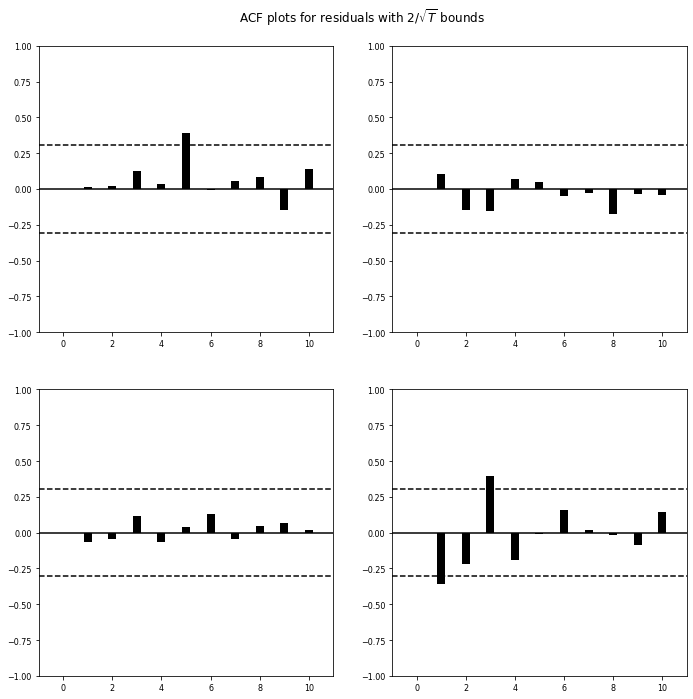

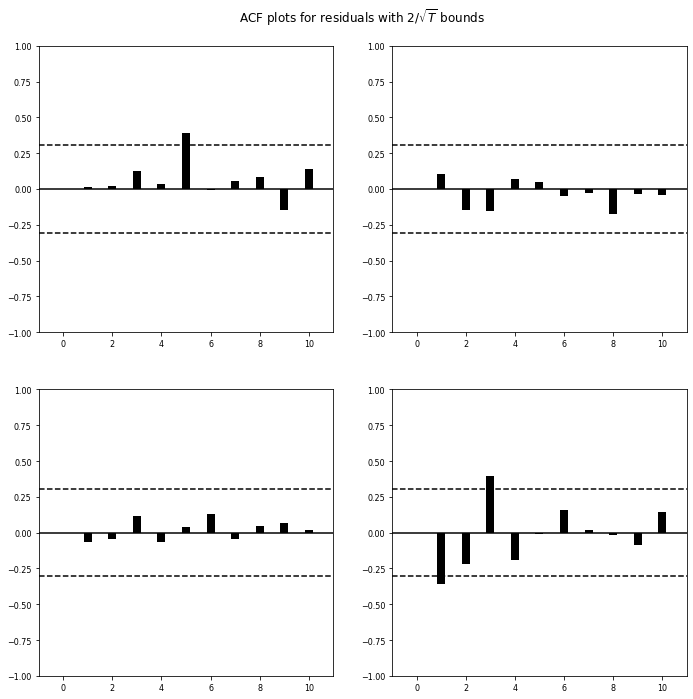

In [36]:
results.plot_acorr()

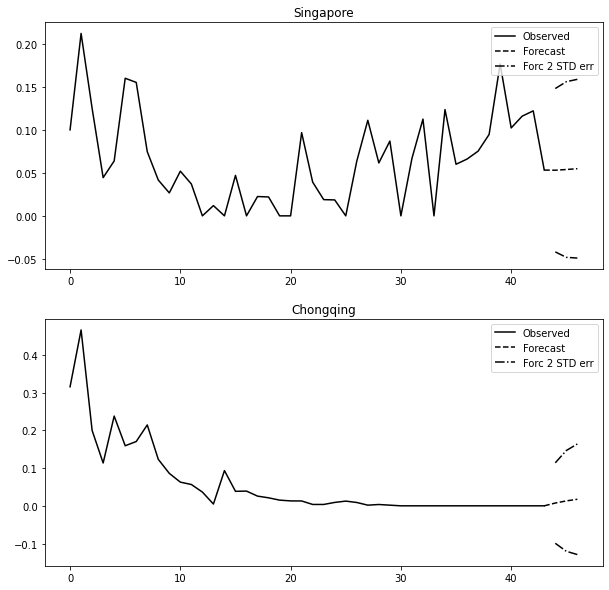

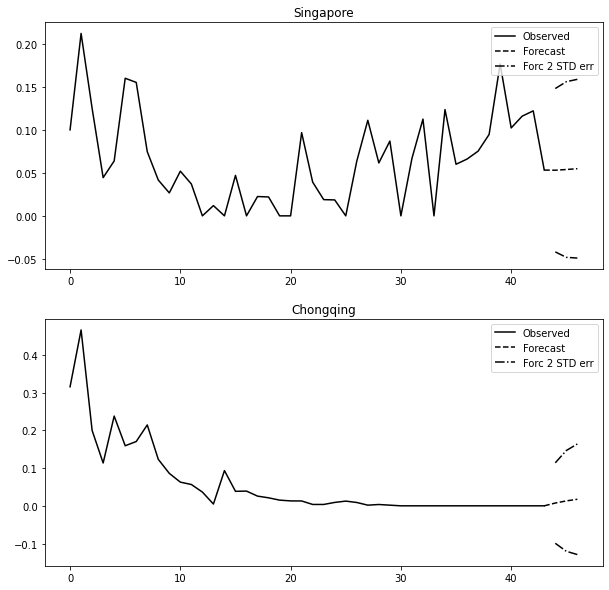

In [37]:
# Make forecast
results.plot_forecast(3)

In [38]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [39]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [40]:
fcst = results.forecast_interval(model_df[['Singapore','Chongqing']].values[-2:,:], 1)

In [41]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Chongqing'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [42]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Chongqing']].values).flatten()

In [43]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Chongqing_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Chongqing_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Chongqing_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Chongqing_f_m','Singapore_f_lo',
                'Chongqing_f_lo','Singapore_f_up','Chongqing_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Chongqing_f_m','Chongqing_f_lo','Chongqing_f_up']] = fcst_df.loc[day_forecat - 1,'Chongqing']

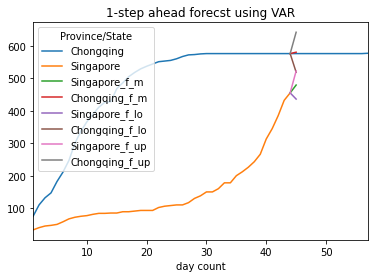

In [44]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

#### Alternative Model explicitly modeling Global Contagion:

In [45]:
clean_df['log_confirmed'] = np.log(clean_df.Confirmed)
model_2_df = clean_df.pivot_table(index = ['month','day'], columns='Province/State',values='log_confirmed').reset_index()
model_2_df = model_2_df[model_2_df.month>='03'] ## using data since March
model_2_df = model_2_df.dropna(axis=1)
model_2_df.columns
## np.exp(model_2_df['United Kingdom'])

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Index(['month', 'day', 'Afghanistan', 'Algeria', 'Anhui', 'Armenia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Beijing', 'Belarus', 'Belgium', 'Brazil',
       'British Columbia', 'Cambodia', 'Chongqing', 'Croatia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland',
       'France', 'Fujian', 'Gansu', 'Germany', 'Greece', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Iceland', 'India', 'Inner Mongolia',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jiangsu', 'Jiangxi',
       'Jilin', 'Kuwait', 'Lebanon', 'Liaoning', 'Lithuania', 'Luxembourg',
       'Macau', 'Malaysia', 'Mexico', 'Monaco', 'Nepal', 'Netherlands',
       'New South Wales', 'New Zealand', 'Nigeria', 'Ningxia',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Philippines', 'Qatar',
       'Qinghai', 'Queensland', 'Romania', 'San Marino', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sich

In [53]:
var_2_model = VAR(model_2_df[['Singapore','Hubei','Thailand','Germany',]])
results_2 = var_2_model.fit(maxlags=1)
results_2.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Mar, 2020
Time:                     08:59:36
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.9624
Nobs:                     21.0000    HQIC:                  -32.7413
Log likelihood:           246.860    FPE:                5.04735e-15
AIC:                     -32.9572    Det(Omega_mle):     2.14807e-15
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              -26.706808        80.325677           -0.332           0.740
L1.Singapore         0.430056         0.169280            2.541           0.011
L1.Hubei             2.546540         7.220781            0.

### Global recover and mortality rate using the latest data available

In [47]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,log_confirmed,recover rate
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28,NaN,NaN,NaN,0.000000,0.000000
1,Afghanistan,Afghanistan,03,22,2020-03-22 21:43:03,40.0,1.0,1.0,2020-03-22,24.0,16.0,0.666667,3.688879,0.025000
2,Albania,Albania,03,22,2020-03-22 12:43:19,89.0,2.0,2.0,2020-03-22,76.0,13.0,0.171053,4.488636,0.022472
3,Algeria,Algeria,03,22,2020-03-22 14:43:07,201.0,65.0,17.0,2020-03-22,139.0,62.0,0.446043,5.303305,0.323383
4,Andorra,Andorra,03,22,2020-03-22 12:43:19,113.0,1.0,1.0,2020-03-22,88.0,25.0,0.284091,4.727388,0.008850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,occupied Palestinian territory,occupied Palestinian territory,03,12,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-12,0.0,0.0,NaN,-inf,NaN
1091,occupied Palestinian territory,occupied Palestinian territory,03,14,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-14,0.0,0.0,NaN,-inf,NaN
1092,occupied Palestinian territory,occupied Palestinian territory,03,15,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-15,0.0,0.0,NaN,-inf,NaN
1093,occupied Palestinian territory,occupied Palestinian territory,03,16,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-16,0.0,0.0,NaN,-inf,NaN


Recovery over total confirmed cases: 34.15%


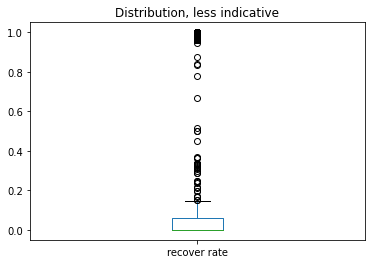

In [49]:
# Recovery rate
latest_df[(latest_df['recover rate'] <= 1) & ((latest_df['recover rate'] >= 0))]['recover rate'].\
    plot.box(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.86%


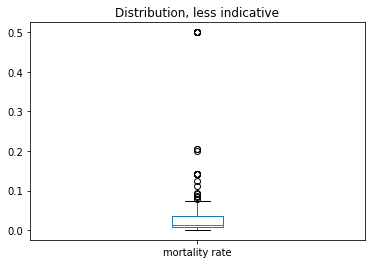

In [50]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df[(latest_df['mortality rate'] < 1) & (latest_df['mortality rate'] > 0)]['mortality rate'].\
    plot.box(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [51]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [52]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)